Before you begin, execute this cell to import numpy and packages from the D-Wave Ocean suite, and all necessary functions for the gate-model framework you are going to use, whether that is the Forest SDK or Qiskit. In the case of Forest SDK, it also starts the qvm and quilc servers.

In [1]:
%run -i "assignment_helper.py"
%matplotlib inline

Available frameworks:
Forest SDK
Qiskit
D-Wave Ocean


# Unitary evolution and the Hamiltonian

**Exercise 1** (2 points). You have already seen that the eigendecomposition of a Hamiltonian gives you the energy levels of the system. This comes out of the time-independent Schrödinger equation, $H|\psi \rangle =E|\psi \rangle$.

The solution of the time-dependent Schrödinger equation establishes the connection between unitary operations (solutions of the Schrödinger equation) and the Hamiltonian. Imagine, for instance, that you are looking for the Hamiltonian that implements the phase gate $S=\begin{bmatrix}1 & 0\\ 0& i\end{bmatrix}$. This is a valid unitary, so we are looking for a time-independent Hamiltonian such that $S = \exp(-i Ht/\hbar)$. The $S$ gate is diagonal, so will be our Hamiltonian. That makes matrix exponentiation easy. So we are looking for a Hamiltonian $H=\begin{bmatrix}h_1 & 0\\0 & h_2\end{bmatrix}$ for some values $h_1$ and $h_2$.

We can take, for instance $\sigma^Z=\begin{bmatrix}1 & 0\\0 & -1\end{bmatrix}$ and substract an identity matrix -- this only shifts the energy. That would give us a Hamiltonian $H=\sigma^Z-\mathbb{1}=\begin{bmatrix}0 & 0\\0 & -2\end{bmatrix}$. So now we have $S=\exp(-i Ht/\hbar)=\begin{bmatrix}\exp(-i 0t/\hbar) & 0\\0 & \exp(i 2t/\hbar)\end{bmatrix}=\begin{bmatrix}1 & 0\\0 & \exp(i 2t/\hbar)\end{bmatrix}$. Calculate the value for $t/\hbar$ to get the $S$ gate from this Hamiltonian. Store the result in a variable called `t`.

In [2]:
import numpy as np
###
t = np.log(1j)/2j
###


In [3]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


This tells you for how long you would have to evolve the Hamiltonian to get the effect of an $S$ gate.

# The adiabatic theorem

**Exercise 2** (2 points). In an adiabatic process, conditions change slowly enough for the system to adapt to the new configuration. We can start from some Hamiltonian $H_0$ and slowly change it to some other Hamiltonian $H_1$, for instance, on a linear schedule: $H(t) = (1-t) H_0 + t H_1$. The speed of change heavily depends on the energy gap, that is, the difference between the ground state energy and the first excited state of all Hamiltonians $H(t)$, $t\in[0,1]$.

It is easy to craft a Hamiltonian where this gap is small, so the speed limit has to be low. If you take a classical Ising model with coupling strengths on vastly different scales, that is what you get. For instance, calculate the gap (the difference between the smallest and second smallest eigenvalue) of the Hamitonian $H_1=-1000\sigma^Z_1\sigma^Z_2-0.1\sigma^Z_2\sigma^Z_3-0.5\sigma^Z_1$ acting on a three-qubit system (the last linear term is there to make the ground state unique). The result should be in a variable called `gap`. Remember that since you have three qubits, the $\sigma^Z_1\sigma^Z_2$ operator, for instance, actually means $\sigma^Z\otimes\sigma^Z\otimes\mathbb{1}$.

In [4]:
import numpy as np
Z = np.array([[1, 0], [0, -1]])
###
ZII = np.kron(np.kron(Z, np.eye(2)), np.eye(2))
ZZI = np.kron(np.kron(Z,Z), np.eye(2))
IZZ = np.kron(np.eye(2), np.kron(Z,Z))
H = -1000 * ZZI - 0.1 * IZZ - 0.5 * ZII
eigenvalues, _ = np.linalg.eigh(H)
gap = abs(eigenvalues[0] - eigenvalues[1])
###
gap

0.20000000000004547

In [5]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**Exercise 3** (1 point). Contrast this to the gap of the Hamiltonian $H_0 = \sum_{i=1}^3 -\sigma^X_i$. Again, calculate the value in a variable called `gap`.

In [6]:
X = np.array([[0, 1], [1, 0]])
###
XII = np.kron(np.kron(X, np.eye(2)), np.eye(2))
IXI = np.kron(np.kron(np.eye(2), X), np.eye(2))
IIX = np.kron(np.kron(np.eye(2), np.eye(2)), X)
H = -XII -IXI - IIX
eigenvalues, _ = np.linalg.eigh(H)
gap = abs(eigenvalues[0] - eigenvalues[1])
###
gap

1.9999999999999998

In [7]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


You can see that there is a vast difference in the gap between the two Hamiltonians. This could be leveraged: for instance, the initial part of the annealing could go faster, since the gap is large, and then slow down towards reaching the target Hamiltonian. The optimal annealing schedule is a research topic on its own.

# Quantum annealing

**Exercise 4** (1 point). On a real quantum annealing device, we drop the stringent theoretical requirements of following the adiabatic pathway and we repeat the transition over and over again. Then we choose the lowest energy solution as our optimum.

The classical 'simulator' for a quantum annealer is some heuristic solver of combinatorial optimization, for instance, simulated annealing. Use the dimod package to implement the Hamiltonian with a small gap: $H_1=-1000\sigma^Z_1\sigma^Z_2-0.1\sigma^Z_2\sigma^Z_3-0.5\sigma^Z_1$. Your solution should be a `BinaryQuadraticModel` in an object called `model`.

In [8]:
import dimod

###
J = {(0, 1): 1000, (1, 2): 0.1}
h = {0:0.5, 1:0, 2:0}
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
###

In [9]:
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
assert np.isclose(response.first.energy, -1000.6)

Unlike in the case of a simple system, you often do not get the ground state:

In [10]:
print([solution.energy for solution in response.data()])

[-1000.6, -1000.6, -1000.6, -1000.6, -1000.6, -1000.6, -999.6, -999.6, -999.6, -999.6]


This shows that the problem is also hard for a classical heuristic solver, which should not come as a surprise.

The qubits are often not fully connected, especially not in superconducting architectures. This is why we have to embed our graph in the connectivity graph of the hardware. In the case of the D-Wave 2048Q system, the connectivity has the Chimera graph structure:

<img src="figures/unit_cell.png" alt="Unit cell in Chimera graph" style="width: 80px;"/>

We are interested in the chain length of an embedding, which reflects how many physical qubits are used to represent a logical qubit. Assume that your quantum device has a Chimera structure of four unit cells, that is, 8 times 4 = 32 qubits.

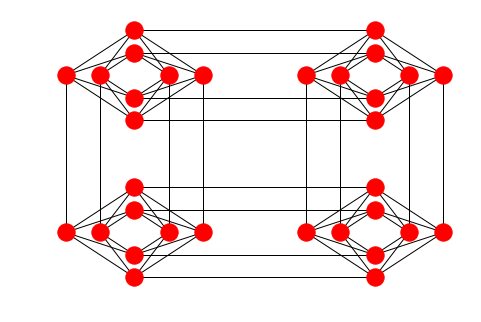

In [11]:
import matplotlib.pyplot as plt
import dwave_networkx as dnx

connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

Let's try to embed the complete graph $K_n$ on eight nodes:

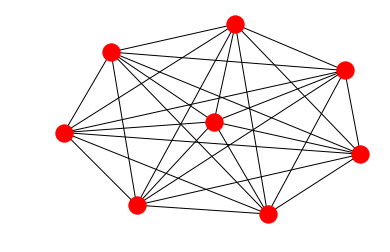

In [12]:
import networkx as nx
G = nx.complete_graph(8)
plt.axis('off') 
nx.draw_networkx(G, with_labels=False)

**Exercise 5** (2 points). The function `find_embedding` of the package minorminer returns you a dictionary: the keys represent the nodes of the graph to be embedded, and the values are a list (the chain) of physical qubits for that particular graph node. Write a function that takes this dictionary and return the length of the longest chain.

In [13]:
###
def get_max_chain_length(embedded_graph):
    max_chain_length = 0
    for _,chain in embedded_graph.items():
        if len(chain) > max_chain_length:
            max_chain_length = len(chain)
    return max_chain_length
###
embedded_graph = {0: [1, 12, 4], 1: [30, 11, 27, 87], 2: [28, 9, 25]}
print(get_max_chain_length(embedded_graph))
embedded_graph = {}
print(get_max_chain_length(embedded_graph))

4
0


In [14]:
embedded_graph = {0: [1, 12, 4], 1: [30, 11, 27, 87], 2: [28, 9, 25]}
assert get_max_chain_length(embedded_graph) == 4
embedded_graph = {}
assert get_max_chain_length(embedded_graph) == 0

**Exercise 6** (2 points). Finding the optimal embedding is NP-hard, so the minorminer package implements a heuristic algorithm that relies on randomness. It often occurs that subsequent runs yield different chain lengths. Run the `find_embedding` function to embed the graph `G` in the graph `connectivity_structure` 100 times. Write the embedding with the shortest maximum chain length to a variable called `shortest_chain`, and the longest one to `longest_chain`. Use the function you wrote above.

In [15]:
###
shortest_chain_length = 32
longest_chain_length = 0
for i in range(100):
    embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())
    if get_max_chain_length(embedded_graph) < shortest_chain_length:
        shortest_chain = embedded_graph
        shortest_chain_length = get_max_chain_length(embedded_graph)
    if get_max_chain_length(embedded_graph) > longest_chain_length:
        longest_chain = embedded_graph
        longest_chain_length = get_max_chain_length(embedded_graph)
###

In [16]:
assert len(shortest_chain) == 8
assert len(longest_chain) == 8
assert get_max_chain_length(shortest_chain) < get_max_chain_length(longest_chain)

Let's plot the embeddings:

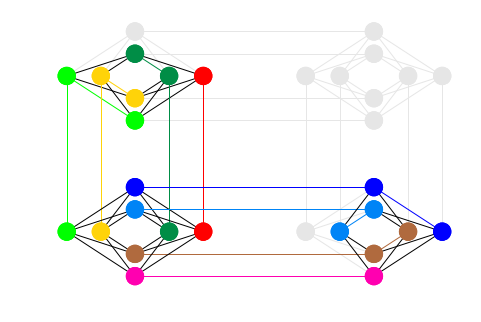

In [17]:
dnx.draw_chimera_embedding(connectivity_structure, shortest_chain)
plt.show()

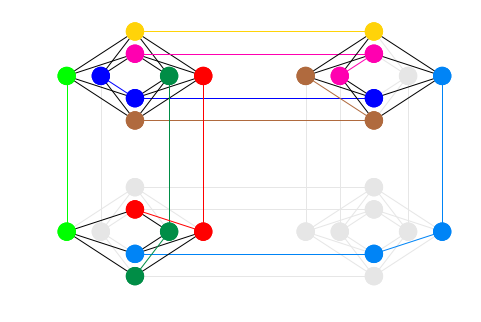

In [18]:
dnx.draw_chimera_embedding(connectivity_structure, longest_chain)
plt.show()

Depending on the heuristic outcome, you have a chance of seeing that the embedding with the longer chains uses more unit cells. Since the optimality of an embedding is hard to guarantee, if we want to use quantum annealing for machine learning, we should think of models that are either easy to embed or for which we can manually construct the optimal embedding.